## Neighborhood-Based Collaborative Filtering

### Introduction

이웃 기반(메모리 기반)필터링은 CF를 위해 개발된 최초의 알고리즘입니다.
유사한 사용자가 유사한 등급 패턴을 표한다는 가정을 하고 있습니다.
이웃 기반의 두가지 기본 유형입니다.

1. User-based collaborative filtering : 비슷한 사용자들(peer group)을 기반으로 대상에게 항목을 추천합니다.
2. Item-based collaborative filtering : 유사한 항목 집합(S)를 찾아서 S를 기반으로 사용자에게 항목을 추천합니다.

두 방식의 차이점은 접근할때 기반이 되는 대상이 다릅니다. 1번 방식은 다른 사용자의 정보를 사용하지만 item기반은 대상 사용자의 데이터를 사용합니다. 이 두 방식은 상호 보완적인 관계입니다. 하지만 달성되는 추천 사항 유형에는 상당한 차이가 있을수 있습니다. 앞 장에서 서술한 대로 user-item rating matrix $R = [r_{ui}]$를 사용합니다. 여기서 row는 사용자, columns는 품목입니다. 상용자의 수는 m, 품목의 수는 n으로 m by n 행렬입니다. 

이웃 기반 방식은 다른 CF방식과 다르게 두가지 방법으로 이루어 집니다.

1. Predicting the rating value of a user-item combination : R의 r(rating)을 예측하는 가장 쉽고 원시적인 방법입니다. 
2. Determining the top-k items or top-k users : Top-k item or user을 결정합니다.
  + 일반적으로 item의 랭킹을 결정하지만 마케팅과 같은 특수한 경우에는 user랭킹도 사용합니다.
  
위 두가지 방식은 서로 관련성이 큽니다. 직관적으로 rating 예측이 가능해야 top-k도 설정할수 있기 때문입니다.  
효율성개선을 위해 일부 데이터를 미리 계산하기도 합니다.(이후에 자세히 설명)

### Key Properties of Ratings Matrices

서술한대로 등급 행렬 R을 사용합니다. R은 상당히 희소한 상태 입니다. 여기서 목표는 등급행렬을 완성하는 것 입니다. feature는 r(seen)이며 target 또한 r(nuseen)인 특이한 구조를 가지지만 cls, reg의 일바화로도 볼 수 있습니다.

1.3.1.1에서 서술한 대로 등급행렬 R은 다양하게 표현됩니다.
1. Continuous ratings : boundary안의 실수로 등급이 매겨 집니다. 이는 사용자가 무한한 값에서 실제 값을 생각해야하는 부담을 주기도 합니다. 하지만 이런 경우는 희귀합니다.
2. Interval-based ratings : {1, 2, 3, 4, 5}와 같이 명시적인 feedback을 얻을수 있습니다. 중요한점은 각 등급값들 사이의 거리(차)가 같아야 합니다.
3. Ordinal ratings : 2번과 유사지만 categorical values로 제공됩니다. {매우 싫음, 싫음, 중간, 좋음, 매우 좋음}. 이러한 등급은 간격간 거리가 다를수 있습니다. 하지만 실제로는 같게 처리합니다. {매우 싫음, 싫음, 좋음, 매우 좋음}과 같이 중립이 없는 경우를 강제 선택이라고 합니다.
4. Binary ratings : 2번과 3번의 특수 경우 입니다. {긍정, 부정}으로 사용자에게 강제 선택이 부과되므로 중립인 경우 종종 피드백을 주지 않는 사용자가 있을 수 있습니다.
5. Unary ratings : 오직 긍정만 표할 수 있습니다. 대표적인 예시로 facebook의 좋아요, 구매정보 입니다. 장점은 모델의 개발을 단순화 할 수 있습니다.

또한 explixit과 implicit으로도 구분 됩니다. 
explicit데이터는 1, 2, 3, 4와 같이 사용자의 선호도를 명확히 제공받을수 있는 데이터 입니다. 하지만 사용자는 explicit feedback을 잘 안줍니다. 그래서 5번과 같은 데이터로 부터 선호도를 암시적으로 판단하여야 합니다. 이를 implicit data라고 합니다.

항목 간의 등급 분포는 종종 **long-tail**속성을 충족합니다. 이는 인기 item들만 등급이 매겨진다는 것을 의미 합니다. 이러한 분포는 추천시스템에서 아래와 같이 중요한 작용을 합니다.

1. 많은 경우 '가성비' 제품의 평가가 많습니다. 실제 상황에서 마진이 큰 item의 평가 빈도가 낮습니다.
  + 다시 말해서 평가가 낮은 빈도의 품목을 추천하는 것이 마진을 크게 남길 수 있습니다. 실제로 아마존에서 long-tail부분의 item을 추천해서 이득 봤다고 합니다😥
2. long-tail의 등급은 매우 희소하기 때문에 모델링에 어려움을 더 합니다. 
  + 실제로 추천시스템을 모델링했을때 인기템을 추천해주는 경향이 있습니다. 이는 다양성을 해치며 사용자가 지루해 할 수 있습니다.
  
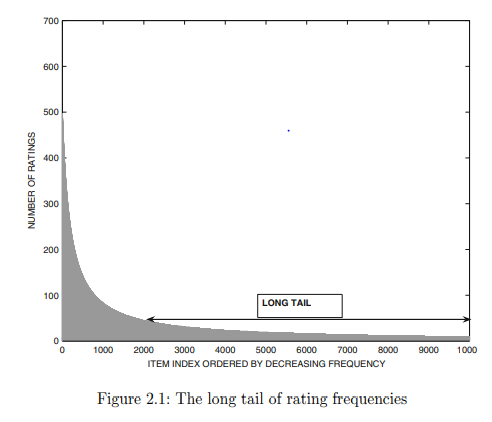

정리 하자면 long-tail 분포의 의미는 자주 평가되는 품목적기 때문에 이웃기반 CF에 악 영향을 줍니다. 그렇기 때문에 알고리즘 조정 전에 희소, long-tail문제를 먼저 확인 하여야 합니다.

###  Predicting Ratings with Neighborhood-Based Methods

이웃 기반의 기본 아이디어는 등급행렬R을 기반으로 user-user or item-item 유사성을 계산한뒤 추천을 진행 하는 것입니다.
이러한 방식은 두가지 원리를 따릅니다.
1. User-based models : 비슷한 사용자는 비슷한 항목에 비슷한 점수를 준다.
2. Item-based models : 같은 사용자가 비슷한 항목에 비슷한 점수를 준다.

다시한번 말하지만 CF는 cls/reg의 일반화로 볼 수 있습니다. 차이점은 CF는 인스턴스가 열이 될수도 있다는 것 입니다.

#### User-Based Neighborhood Models

사용자 기반 이웃 모델은 대상 사용자와 다른 모든 사용자들의 유사도를 측정합니다. 즉 유사도 함수를 정의할 필요가 있습니다. 유사도 함수는 코사인, 피어슨, 자카드등 다양한 함수가 사용될 수 있습니다. 유사도 함수를 정의 하는데 어려운 점은 사용자들의 편향이 존재 한다는 것 입니다. 예를들어 공정한 순호는 영화에 정직한 점수를 주지만 쪼잔한 창우는 대부분 1~3점을 줍니다. 따라서 이런 편향을 고려하는 과정이 필요합니다. 

다음은 유사도를 계산하는 방법입니다. 먼저 각 사용자별 평균$\mu_u$을 계산 해야 합니다. 
여기서 $I_u$는 사용자 u가 평가한 item 집합입니다.

$$\mu_u = \frac{\sum_{k \in I_u} r_{uk}}{I_u} \forall u \in {1, ..., m}$$

그런 다음 사용자간의 유사도를 계산합니다. 여기서는 유사도를 피어슨 상관계수로 하였습니다.

$$ Sim(u, v) = Pearson(u, v) = \frac{\sum_{k \in I_u \cap I_v}(r_{uk}-\mu_u)\cdot(r_{vk}-\mu_v)}{\sqrt{\sum_{k \in I_u \cap I_v}(r_{uk}-\mu_u)^2}\cdot\sqrt{\sum_{k \in I_u \cap I_v}(r_{vk}-\mu_v)^2}}$$

피어슨 상관계수는 간단합니다. 중요한 점은 모든 계산은 $I_u \cap I_v$ 에서만 계산해야 합니다. 하지만 실제로는 위의 식처럼 각 사용자의 평균을 계산합니다. 왜냐하면 간단합니다! 정석은 매번 공통 집합에서 계한해야합니다!

사용자들간 유사도를 계산하였으면 가장 유사한 K명의 사용자 top-k 사용자들의 점수를 가중 평균하여 rating $r$을 예측 합니다. 하지만 위에서 말한 사용자 편향이 있으니 식을 조금 수정합니다. 사용자들의 점수를 사용하기 전에 각 사용자별로 평균을 빼주어서 mean-centered rating $s_uj$를 계산합니다.

$$ s_{uj} = r_{uj} - \mu_u \forall u \in \{1,\dots,m\}$$

이제 평균 중심화 된 점수로 예측을 수행합니다.

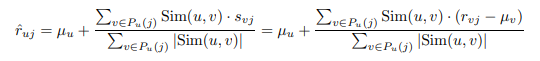

**Example of User-Based Algorithm**  
정리를 위해 예시를 가지고 연습해 봅시다!

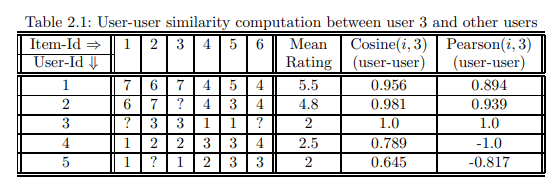



사용자 3의 등급을 예측하기 위하여 가장 유사도가 높은 사용자 1, 2를 사용하겠습니다. 즉, K=2입니다. 평균-중심화를 하지 않고 등급을 계산하면 다음과 같습니다. 일반적으로 피어슨이 평균-중심화의 편향 조정 효과 때문에 cos보다 선호 되므로 피어슨으로 계산 하겠습니다.

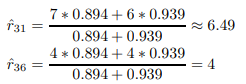

하지만 편향이 존재 하기 때문에 먼저 편균화 시키고 점수를 예측한다음 다시 평균을 더해주겠습니다. 평균화된 R은 다음과 같습니다.
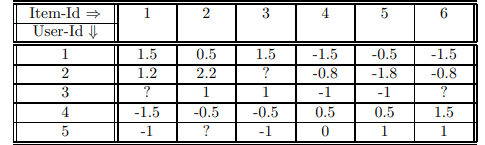

다시 계산을 하면 다음과 같습니다
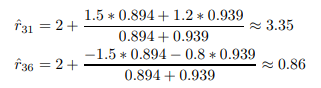

#####  Similarity Function Variants

앞서 서술 했듯이 유사도 함수는 다양합니다. 한 가지 변형은 평균 중심 등급이 아닌 원시 등급에 코사인 함수를 사용하는 것입니다.

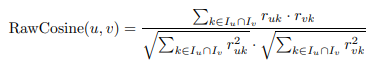

비슷하지만 일부는 다음과 같이 사용하기도 합니다.

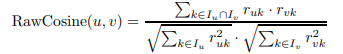

이러한 변형의 이유는 유사도 sim(u,v)는 공통인자에 영향을 받습니다. 따라서 공통인자가 적을 경우 가중치를 줄여줘야 합니다. 이를 significance weighting(유의성 가중치)라고 합니다.

유사도 함수의 또다른 변형은 유의성 가중치를 고려한 discounted similarity 입니다. 이는 기존 유사성 함수를 threshold Beta값을 통해 의해 조정합니다. 

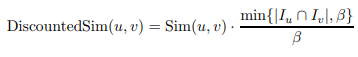

즉 공통 인자가 Beta보다 많을 경우 그대로 사용하고 Beta보다 적을 경우 조정을 시행 합니다.

##### Variants of the Prediction Function
유사성 함수와 마찬가지로 예측 함수또한 다양한 변형 사항이 있습니다. 그중 표준 편차를 활용한 방식은 직관적으로 편향을 잘 잡아줄 것 이라고 예상 됩니다. 

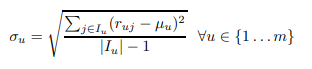

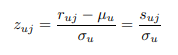

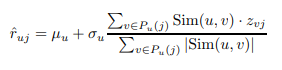

이 z-score의 문제는 예상된 등급이 rating boundary를 넘길수도 있다는 것입니다. 하지만 일반적으로 그대로 사용가능 하답니다...?

##### Variations in Filtering Peer Groups

필터링 되는 피어그룹 또한 변형이 존재합니다. 가장 간단한 Top-k 유사도 그룹을 고려해봤을때 약하거나, 부정적인 상관관계가 포함된 경우 성능이 매우 나빠집니다. 따라서 이러한 사용자는 피어그룹에서 필터링 될수 있습니다.

##### Impact of the Long Tail

long-tail효과가 부정적인건 앞서 설명했습니다. 이는 NLP의 불용어 처럼 예측에 나쁜 영향을 미칩니다. 따라서 IDF를 사용하려는 시도가 있습니다. 각 가중치를 다음과 같이 계산합니다.(idf의 방식과 동일합니다.)

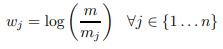

계산 한다음 유사도를 계산할 때 곱해주어 long-tail의 악영향을 줄여줍니다.

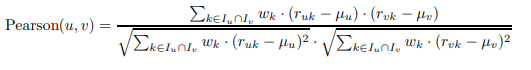

####  Item-Based Neighborhood Models

item-based 접근법과 user-based접근법의 차이점은 peer group이 item인것입니다. 따라서 계산 함수가 조금 변형되고 전체적인 과정은 동일합니다. 또 다른점은 피어슨 함수보다 코사인 함수가 더 좋다는 것입니다. 이에 이번 챕터에서는 adjusted cosine similarity를 사용합니다. 

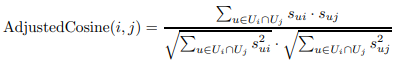

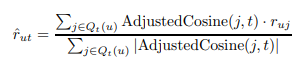

**Example of Item-Based Algorithm**

바로 예제로 넘어가 보겠습니다. 위에서 사용한 예제를 그대로 사용하겠습니다.

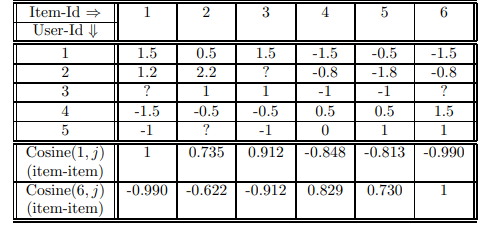

평균화를 하고 adjusted cosine similarity를 이용하여 계산하면 다음과 같습니다.

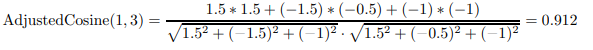

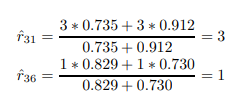

위에서 계산한 결과와 비슷하게 나오는것을 확인 할 수 있습니다.

#### Efficient Implementation and Computational Complexity

이웃기반은 최상의 항목 추천을 추정합니다. 즉 ranking은 고려하지 않습니다. ranking을 위해서는 중간 계산을 저장하고 ranking 을 위한 작업이 추가로 필요합니다.

이웃 기반 접근법은 online과 offline 페이즈로 나눠집니다.
1. Offline : 모든 사용자, 항목들의 유사도를 계산합니다. 즉, 피어 그룹을 찾는 과정입니다.
2. Onlien : rating 예측을 시행 합니다.
이러한 과정으로 나누는 이유는 계산 복잡도 때문 입니다. 일반적으로 사용자와 항목의 수가 크다 보니 행렬곱을 계산할때 매우 많은 컴퓨팅 자원과 시간이 필요합니다. 이를 위해 전체 행렬에 대한 계산은 offline에서 이루어지고 상대적으로 매우 작은 피어그룹에서의 계산은 online에서 이루어집니다.

####  Comparing User-Based and Item-Based Methods

일반적으로 item-based 방법이 더 잘 추천해 주는경우가 많습니다. 이는 사용자 자신의 평가로 계산되므로 중복도가 있긴하지만 사용자가 좋아하는 항목을 잘 추천해줍니다. 또한 shilling attack에도 좋은 모습을 보여줍니다. 하지만 다양성 관점에서는 user-based 방식의 성능이 좋습니다.

**shilling attack** : 경쟁사의 평점을 악의적으로 낮추는 공격

~사실 정확도는 데이터가 결정합니다.~

설명가능성도 차이가 있습니다. item-based 방식은 추천시 다음과 같은 문구로 사용자에게 설명해 줄 수 있습니다.
> Because you watched “Secrets of the Wings,” 

하지만 user-based는 아래와 같이 그래프를 그려볼 수 있지만 사용자의 취향과의 직접적인 관계를 모르기 때문에 제한 적입니다.

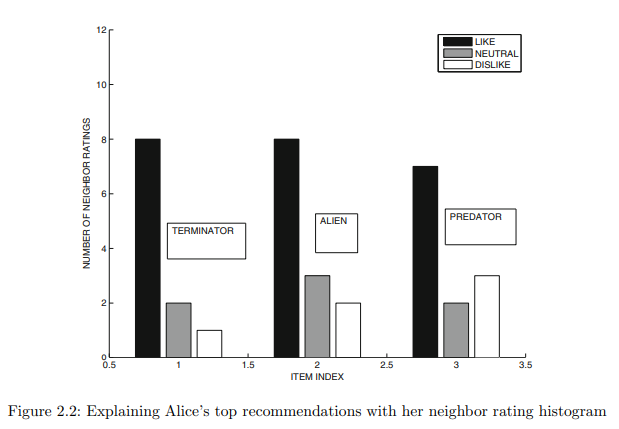

또한 item-based는 등급의 편향에 안정 적입니다. 일반적으로 사용자가 아이템보다 훨~씬 많고 신규 사용자가 신규 아이템보다 많기 때문입니다. 즉, 사용자 기반 방식의 유지 보수가 더 어렵습니다.

#### Strengths and Weaknesses of Neighborhood-Based Methods

이웃 기반 방식은 단순, 직관적인 접근에 관련된 몇가지 장점이 존재합니다.
1. 구현과 디버그가 쉽습니다.
2. 추천에 대한 해석이 가능합니다.(특히 item-based)
3. 새로운 user와 item에 대한 안정성이 있습니다.

반대로 단점은
1. 계산이 복잡합니다. (최대 O(m^2))
2. 희소한 데이터에 취약합니다. 

대부분의 데이터가 희소하기 때문에 단점이 크게 부각되어 보입니다.

####  A Unified View of User-Based and Item-Based Methods

두 방식의 장,단점이 명확함에 따라 통합 방법도 시도해 볼 수 있습니다. 먼저 통합방식을 사용하기 위해서는 평균 중심화가 되어 있어야 합니다. (평균-중심화가 되고 나면 user, item방식 둘다 비슷해집니다. 실제로 행이 평균 중심이 되면 행 사이의 피어슨 계수와 코사인 계수가 동일해 집니다.) 그 다음 각각 방식으로 rating을 예측하여 가중 조합합니다.

결합 방식의 일반화된 방식은 다음과 같습니다.(이 외에 다양한 방식이 존재합니다)
1. 행과 열의 유사도 합을 구하여 가장 유사한 item을 선택합니다. 
2. 위에서 구한 item의 rating가중치 조합으로 예측을 진행 합니다.

### Clustering and Neighborhood-Based Methods

이웃 기반 방식의 주요 과제는 이웃을 찾는중 계산 복잡도 입니다. 따라서 이웃을 찾는 단계를 클러스터링 기반 방법으로 시행하는 시도가 있습니다. 실제로 정확도는 떨어질수 있지만 계산효율성이 증가합니다. 정확도가 떨어지는 이유는 역시나 희소한 데이터 입니다. 데이터가 불완전하다는 것은 클러스터도 불완전 하기 때문입니다. 그나마 맨해튼 거리를 사용한 K-means 방식이 낫다고 합니다.

###  Dimensionality Reduction and Neighborhood Methods

차원 축소 방식은 sparse한 데이터를 dense하게 바꾸기 때문에 유사도 측정에 도움이 되고 계산 효율성과 성능이 증가 합니다.
두가지 차원 축소 방식이 있습니다. 이후 자세한 설명이 나오므로 여기서는 간단히 설명하고 넘어 갑니다.
1. 행 or 열 기준으로 차원을 축소 시켜 이웃 기반에 사용하는 방식입니다.
2. 행과 열 동시에 latent representation으로 바꾸는 방식입니다. 이는 이웃기반이 아니므로 다음에(3장) 설명합니다.

1번 방식은 SVD, PCA방식이 있습니다. 하지만 두 방식 모두 계산하기 위해서는 missing value가 있으면 안됩니다.  
~누락값을 더 잘 예측하기 위하여 누락값을 먼저 계산해야하는 이상한 상황에 놓이게 됩니다.~  

이를 위해 가장 간단한 방식은 평균으로 값을 채우는 것입니다. 평균으로 채운 행렬을 $R_f$라고 하겠습니다. 여기서는 SVD로 설명합니다. SVD를 하는 $S=R_f^TR_f$ 라고 하겠습니다.



truncated svd의 $P_d$와 $R_f$를 연산한 값($R_f P_d$)이 축소된 등급 행렬 입니다.
SVD와 PCA의 자세한 이론은 선형대수 기본지식이 필요합니다. ~알아서 찾아보세요~

#### Handling Problems with Bias

앞서 차원 축소를 시행 하기 위해서 누락값을 평균으로 채운다고 했습니다. 하지만 이는 상당한 편향을 발생 시킵니다. 예를들어 아래의 표의 누락값을 평균으로 채운다음 상관관계를 계산해 보겠습니다.

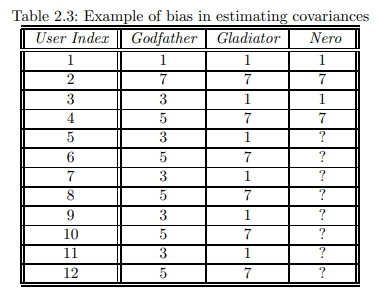

표를 봤을떄 직관적으로 Gladiator와 Nero의 상관관계가 Gladiator와 Godfather의 상관관계보다 크다는 것을 알 수 있습니다. 하지만 평균으로 채운후 상관관계를 계산해보면 아래와 같습니다.

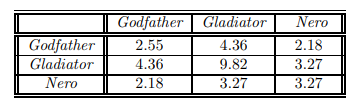

결과를 보면 Gladiator와 Nero의 상관관계가 Gladiator와 Godfather의 상관관계 보다 작게 나옵니다. 이는 상당히 잘못된 결과 입니다. 다시말해, 편향을 줄이기 위한 방법을 설계하여야 합니다.

##### Maximum Likelihood Estimation

아래는 EM방식으로 채운후 상관관계를 계산한 값입니다. 딱봐도 평균보다 좋습니다. ~역시 자세한 설명은 구글링하면 나옵니다~

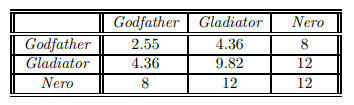

##### Direct Matrix Factorization of Incomplete Data

EM방식은 공분산 추정의 편향을 어느정도 수정 할 수 있지만 등급 행렬이 희소한 경우 성능이 낮아집니다. 즉, 희소할수록 신뢰도가 낮아지고 Robust하지 않습니다. 보다 직접적인 방법은 Matrix Factorization방식입니다. 이는 다음장에 자세히 설명 됩니다.

###  A Regression Modeling View of Neighborhood Methods

또 나왔습니다. 이 책에서 이웃 기반 방식은 기존 ML방식의 휴리스틱 방법론이라고 강조합니다. 여기서는 linear Regression관점의 방식이 꽤나 자세하게 설명되는데 기존 linear Regression과 크게 다르지 않아 넘어갑니다. ~절대 귀찮아서가 아닙니다~

### Graph Models for Neighborhood-Based Methods

개인적으로 공부하면서 이웃 기반 방식중 가장 흥미로운 모델입니다. 그래프 모델은 네트워크 도메인에서 강력합니다. 그래프론의 간단한 지식이 필요하지만 지금 나오는것들은 구글링 하면 금방 나옵니다.

#### User-Item Graphs

그래프에서 이웃을 정의 하기 위해 유사도 함수 대신 user-item 항목 그래프에서 구조적 측정을 사용 할 수 있습니다. 이는 희소행렬에서 더욱 효과 적입니다. user-item 그래프는 user vertex, item vertex와 연관성을 나타내는 edge로 이루어져있습니다. 다시말해 사용자 u가 아이템 i에 평가하면 vertex u와 vertex i에 edge가 존재합니다. 이는 이분그래프 $G = (N_u \cup N_i, A)$로 정의 됩니다.

그래프 방식의 장점은 유사한 이웃을 정의 하기 위해 공동으로 평가한 항목이 많이 않아도 된다는 것 입니다. 즉, 행렬의 희소성에 강려크 합니다. 피어슨 상관계수의 경우, 이웃이 의미 있게 정의 되려면 두 사용자의 공통 항목 세트가 직접 연결 되어 있어야 합니다. 하지만 그래프에서는 랜덤 워크로 여러 단계를 거치기 때문에 간접 연결도 고려합니다.

##### Defining Neighborhoods with Random Walks

그래프에서 이웃의 정의는 다음과 같습니다.
+ Random wark에서 자주 만나는 사용자 집합을 이웃이라고 한다  

이렇게 정의하면 자주 만나는 건 뭔데? 빈도는 어떻게 측정해? 와 같은 의문점이 생깁니다. 이는 구글의 웹 랭킹 PageRank와 유사 합니다. 

##### Defining Neighborhoods with the Katz Measure

위에서 가진 의문들을 설명해 줍니다. 먼저 측도를 정의 합니다.

**Definition 2.7.1 (Katz measure)** Let $n^{(t)}_{ij}$ be the number of walks of length t between nodes i and j. Then, for a user-defined parameter β < 1, the Katz measure between nodes i and j is defined as follows:

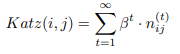

여기서 $n^{(t)}_{ij}$는 i에서 j 까지 길이가 t인 walk의 갯수입니다. β는 하이퍼 파라미터로 길이에 따른 감소 가중치 입니다. 
식을 해석하자면 간단히 i에서 j까지 가는 방법이 많으면 유사하다~ 입니다.

이를 계산하기 위해서는 상당한 자원이 소모됩니다. 여기서 PageRank에서 적용되었던 방식과 유사한 식이 나옵니다. 여기서 β는 A의 가장 큰 고유치의 역수보다 낮게 설정해야 한다고 합니다

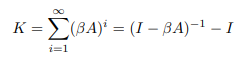

여기서 K는 사용자 쌍의 Katz 계수 입니다. A는 인접행렬입니다.  
Katz 계수가 계산되면 가장 큰 Top-k 항목으로 에측을 시행합니다. 예측은 기존과 같이 이웃들의 평점을 가중평균한 값입니다.

####  User-User Graphs

user-item 대신 user-user 그래프를 직접 만들수 있습니다. 이 방법의 장점은 edge가 더 많은 정보를 제공한다는 것 입니다. 이는 그래프에서 edge가 존재하는 2-hops 연결이 두 사용자 간의 공통 item의 수와 유사성을 직접 고려하기 때문입니다. 그래프는  vertex u와 Horting의로 정의된 edge로 구성됩니다. 

**Definition 2.7.2 (Horting)** A user u is said to hort user v at level (F, G), if either of the following are true:

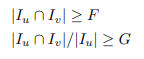

여기서 F, G는 매개 변수 입니다. 위 정의를 해석하면 사용자 u와 v가 동시에 평가한 항목의 갯수가 F이상 이면서 전체에 대한 비율이 G보다 크다면 사용자 u는 level (F, G)에서 사용자 v에 hort 라고 합니다. 처음 보면 잘 이해가 되질 않습니다. 이럴때는 예시를 들어보면 쉽습니다. 

$F = 1, G = \frac{1}{3}$ 일때 $I_u = \{a, b, c, d\}, I_v = \{a, e, f, g, h\}$ 라면 u는 level (1, 1/3)에서 v에 hort가 아닙니다.

같은 F, G값에서 $I_u = \{a, b, c, d\}, I_f = \{b, d, e, f, g, h\}$ 라면 u는 level (1, 1/3)에서 f에 hort 입니다.

간단히 공통 항목이 기준치 이상이면 hort구나 라고 이해 했습니다.

**Definition 2.7.3 (Predictability)** The user v predicts user u, if u horts v and there exists a linear transformation function f(·) such that the following is true:

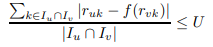

여기서 U는 매개변수 입니다. 마찬가지로 해석해보자면 사용자 u가 매긴 점수와 v가 매긴 점수 함수값($f$)의 맨해튼 거리 합을 공통 항목 수로 정규화한 값이 $U$보다 작으면 v로 u를 예측 가능하다 라고 합니다.

여기서 중요해 보이는 함수 $f$에 대한 설명은 나오지 않습니다. 아마 이후 장에서 나오지 않을까 싶습니다. 위의 정의를 바탕으로 user-user 그래프를 그려본 예시는 다음과 같습니다.

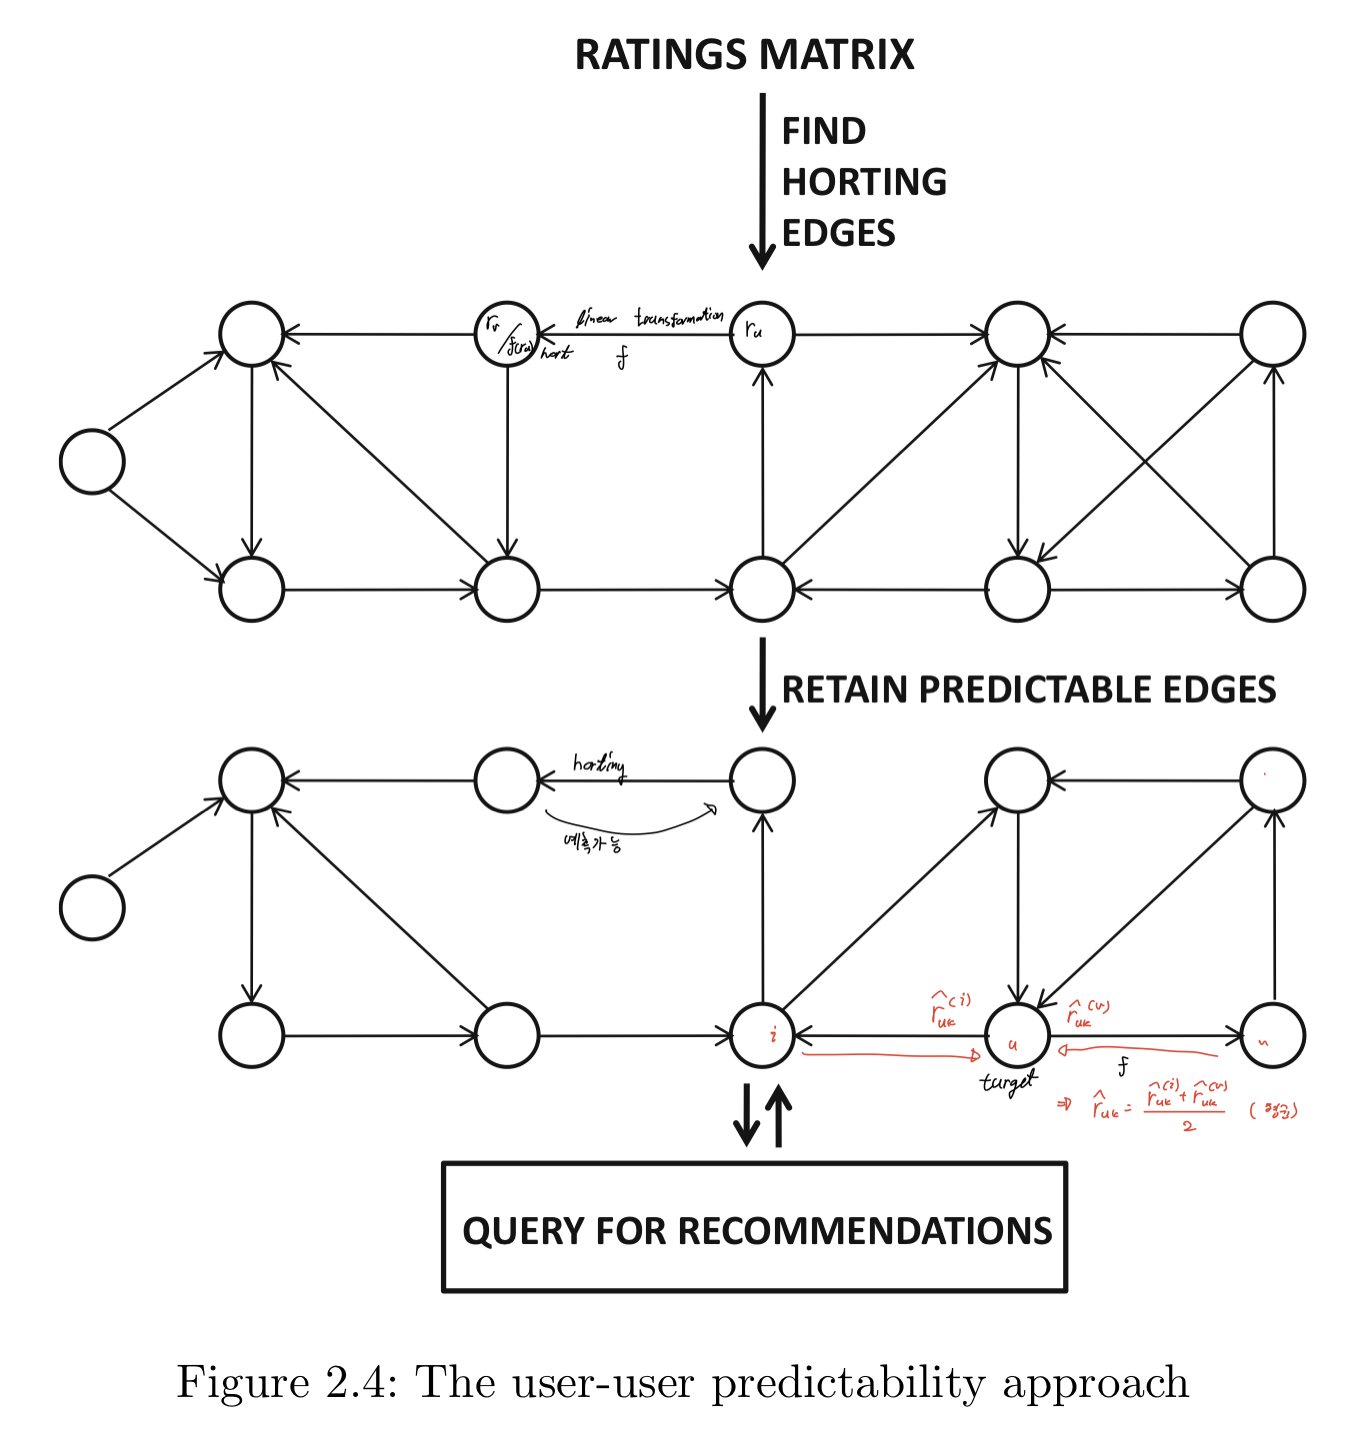

위 그래프에서 horting의 방향과 예측 가능성은 서로 반대 입니다. 즉, v가 u를 예측하려면 u는 hort v를 가져와야 합니다(u에서 v로 가는 e가 있다) 이 그래프에서 e는 선형 변환 f에 해당합니다. 

이러한 방법은 전이성을 사용하기 때문에 희소 행렬에 유리합니다. 이웃방식의 고질적인 문제점인 희소 행렬에 대한 커버리지가 우수합니다.

#### Item-Item Graphs

item-item그래프는 $G(N, A)$로 정의 됩니다. N은 item이고 A는 relationship 입니다. 정의가 간단하기 때문에 그림을 보면 바로 이해가 됩니다. 

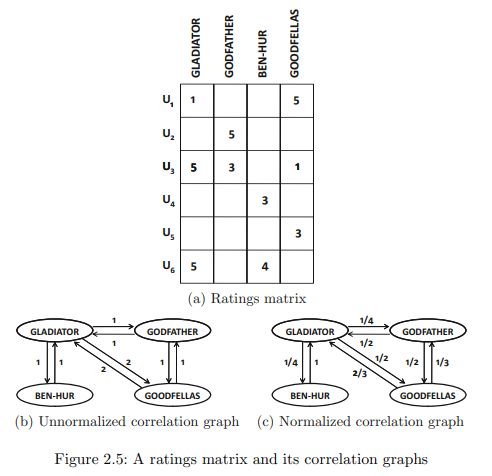

여기서 edge에 대한 가중치가 나오는데 각 꼭지점에서 나오는 outline들의 합이 1이 되도록 정규화 해주면 됩니다. item-item 그래프에서 특이한 점은 등급 값을 사용하지 않는다는 것 입니다. ~별로 안좋아 보이는데~ 자세한 내용은 10장에 나옵니다.

###  Summary

CF는 cls와 reg의 일반화 입니다.   
이웃 기반 방식은 가장 가까운 이웃 분류, 예측(회귀) 두 단계로 구성됩니다.   
이웃 기반 방식은 유사성 값을 사용하여 휴리스틱 방식으로 가중치를 선택하는 Reg로 배울수도 있습니다. 정리에서는 넘어갔습니다.  
이웃 기반에서 가장 고질적인 문제인 희소 문제는 차원축소, 그래프 기반 으로 해결 될 수 있습니다.

### Exercises

1장과 마찬가지로 저의 풀이를 적도록 노력해보았습니다. 틀린부분이 있다면 저에게 Explicit feedback을 주신하면 감사하겠습니다!

1. Consider the ratings matrix of Table 2.1. Predict the absolute rating of item 3 for user 2 using:(Use a neighborhood of size 2 in each case)
  1. User-based collaborative filtering with Pearson correlation and mean-centering
  2. Item-based collaborative filtering with adjusted cosine similarity  
  
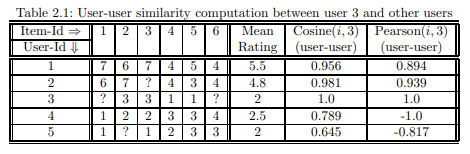

> 복습차원에서 손으로 계산하려 했으나 생각보다 귀찮아서 컴퓨터로 계산했습니다
1. 사용자 2와 가장 가까운 이웃은 사용자 1, 3이고 rating까지 계산하니 6.262 나왔습니다. 등급이 이산형이므로 최종적으로 6이 되겠네요
2. 아이템 3과 가장 가까운 이웃은 아이템 1, 2이고 rating은 5.60입니다. 역시 반올림하면 6으로 사용자 기반과 동일하게 나옵니다.

2. Consider the following ratings table between five users and six items:(Assume that a peer group of size at most 2 is used in each case, and negative correlations are filtered out.)
  + Predict the values of unspecified ratings of user 2 using user-based collaborative filtering algorithms. Use the Pearson correlation with mean-centering.
  + Predict the values of unspecified ratings of user 2 using item-based collaborative filtering algorithms. Use the adjusted cosine similarity.
  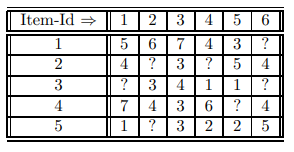
  
> 이번에는 비어있는 값이 2개 입니다. 피어 그룹이 최대 2면서 음수 상관관계는 필터링 하라고 했으니 1개만 양수값이고 나머지는 음수인 경우가 있지 않을까 예상해봅니다.
1. 역시 사용자 4를 제외하고 나머지는 음수가 나옵니다. 더 계산할 것도 없이 사용자 4에다가 편향값만 계산해주면 됩니다. 계산하면 각각 3.53과 5.53 이므로 4, 6점이 되겠습니다.
2. 2번 아이템과 가장 유사한 아이템은 3번과 6번 입니다. 특히 6번은 겹치는 항목이 한개인데 동일하여 유사도가 1으로 나옵니다 계산을 해보면 3.58이 나옵니다 반올림해서 4점입니다.  
  4번 아이템과 가장 유사한 아이템은 1번과 5번입니다. 계산하면 4.30이 나옵니다. 마찬가지로 반올림하면 4점입니다.  
>
> 1번문제와 다르게 사용자 기반과 아이템 기반의 예측값이 다르게 나왔습니다.

3. Discuss the similarity between a k-nearest neighbor classifier in traditional machinelearning and the user-based collaborative filtering algorithm. Describe an analogous classifier to item-based collaborative filtering.

> 1. 요약에는 간단하게 설명하였지만 2.4절의 내용입니다. 사용자 기반 CF는 두가지 단계로 진행됩니다. 대상 사용자와 유사한 이웃 사용자 찾기, 유사한 이웃 사용자로부터 대상 사용자 점수 예측하기, 여기서 첫번쨰 단계인 이웃 사용자 찾기는 k-nearest neighbor classifier와 유사합니다. 사용자들을 피어 그룹으로 분류하고 대상 사용자가 속해있는 클러스터를 찾으면 됩니다. 이는 계산 효율성은 증가하지만 정확도가 떨어지는 문제점이 존재합니다. 이를위해 각 클러스터의 거리를 맨해튼 거리로 측정하면 조금더 나은점이 있습니다. 이는 본문을 읽어보면 좀더 자세히 설명되어 있습니다. 차이점은 3.1장에 소개 되는 문제와 같습니니다. 
2. 항목 기반의 기본 아이디어는 유사하다고 판단되는 항목들을 클러스터링 하여 대상 사용자가 이전에 높게 평가한 항목들이 많이 속해있는 클러스터로 부터 추천을 진행합니다. 항목들을 클러스터링 하는 과정에서 featuer정보가 암시적으로 활용되므로 featuer들의 분류를 정보량 기준으로 분류하는 tree기반 classifier와 유사하다고 생각됩니다.

4. Consider an algorithm that performs clustering of users based on their ratings matrix and reports the average ratings within a cluster as the predicted items ratings for every user within a cluster. Discuss the effectiveness and efficiency trade-offs of such an approach compared to a neighborhood model.

> 이웃 기반 방식은 피어 그룹을 찾는 과정에서 평가된 항목들의 교집합을 기준으로 계산을 진행합니다. 이는 문제에서 제시한 방식으로 평균으로 대체하여 진행될 수 있습니다. 이는 매번 교집합을 찾는 과정이 생략되므로 상당한 계산 효율성 증가 효과를 기대할 수 있습니다. 하지만 평균으로 대체 하는 방식은 사용자들간의 편향을 고려하지 못하기 때문에 정확도가 상당히 떨어집니다. 이는 EM, SVD와 같은 알고리즘으로 보완할 수 있습니다. 

5. Propose an algorithm that uses random walks on a user-user graph to perform neighborhood-based collaborative filtering. \[This question requires a background in ranking methods.\]

> Predictability edge까지 계산한 user-user graph에서 Katz 계수 행렬을 구할수 있습니다. 이는 random wark로 유사한 node를 구하는 방식이므로 top-k이웃을 구할 수 있습니다. 또한 Predictability edge에서 계산되므로 공통으로 평가된 항목의 유사함 정도도 고려합니다. 이는 본문에 나온 pagerank방식을 user-user graph에 반영한 것입니다.   
사실 중요한건 linear transformation function f의 정의가 중요해보이는데 이는 책에서 설명이 없어서 따로 찾아봐야 할 것 같습니다.ㅠ

6. Discuss various ways in which graph clustering algorithms can be used to perform neighborhood-based collaborative filtering.

> 본문에서 나온 방법말고 바로 생각나는 것은 그래프 방식의 클로스터링은 스펙트럼 군집화입니다. 이는 노드간 유사도를 활용하기 떄문에 이웃기반의 기본 아이디어와 동일하다고 생각됩니다. 

7. Implement the user-based and item-based collaborative filtering algorithms.

> 갑자기 구현문제가 나왔습니다. 이럴줄알았으면 1,2번 풀때 좀 공들여서 할껄 그랬습니다.ㅠ
```python 
def adj_cos(row1, row2):
    nan_idx = ~(np.isnan(row1) | np.isnan(row2))
    row1 = row1[nan_idx]
    row2 = row2[nan_idx]
    numerator = np.nansum(row1 * row2)
    denominator = np.sqrt(np.nansum(np.power(row1, 2))) * np.sqrt(np.nansum(np.power(row2, 2)))
    return numerator/denominator
```
1,2번 풀때 사용했던 adj_cos함수 하나만 적고 넘어가겠습니다. 나머지 find top-k user, predict_rating함수는 나중에 구현해보겠습니다.

8. Suppose you had content-based profiles associated with users indicating their interests and profiles associated with items corresponding to their descriptions. At the same time, you had a ratings matrix between users and items. Discuss how you can incorporate the content-based information within the framework of graph-based algorithms.

> 지금 4장을 읽고 있는데 4장에서 소개하는 콘텐츠 기반 모델과 그래프 기반을 통합하라니... 한번 생각해보고 지나가도록 해보겠습니다. 그래프 구조에서 콘텐츠 정보를 통합하는 방법을 생각해보면 좋을것 같습니다. 여기서 사용자의 관심사를 나타내는 프로필과 아이템의 프로필은 키워드로 전처리 된 상태라고 생각해보겠습니다. 기본 아이디어는 PageRank에서와 같이 random wark로 유사한 이웃을 찾는데 각 random wark에 각 키워드의 중복도 비율을 확률값으로 이용하면 좋을것 같습니다. 

9. Suppose that you had a unary ratings matrix. Show how collaborative filtering algorithms can be solved using content-based methods by treating the ratings of an item as its features. Refer to Chapter 1 for a description of content-based methods. What type of a content-based classifier does an item-based collaborative filtering algorithm correspond to?

> 